# Lesson 2: CNN Transfer Learning with Hyperparameter Tuning

This lesson is dedicated to the use of Convolutional Neural Network for solving a multi-class classification task, meaning that there are more than two classes to predict and they are mutually exclusive.

The dataset employed for this task is the flower photo dataset containing 3,670 images of flowers divided in 5 classes: daisy, dandelion, rose, sunflower, and tulip.

## Import Libraries

In [1]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.0 MB/s eta 0:00:00


In [2]:
import tensorflow as tf
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.optimizers import Adam
import optuna
import PIL
from transfer_learning_utils import get_model, show_images, get_pre_trained_model, display_history, append_history

## Reproducibility

Generally, deep learning models are not deterministic, meaning that the same model trained on the same data may produce different results. This is due to the fact that the weights of the model are initialized randomly and the order of the data is shuffled. Therefore, to make the results reproducible, we need to set the random seed for the random number generators of the libraries used in the project.

In [3]:
seed = 42
tf.keras.utils.set_random_seed(seed)

## Download and Prepare data

In [4]:
!wget "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
!tar -xf flower_photos.tgz
!mkdir ./models

--2024-10-25 07:18:13--  https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.134.207, 142.251.107.207, 74.125.196.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.134.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228813984 (218M) [application/x-compressed-tar]
Saving to: ‘flower_photos.tgz’

flower_photos.tgz   100%[===================>] 218.21M   201MB/s    in 1.1s    

2024-10-25 07:18:14 (201 MB/s) - ‘flower_photos.tgz’ saved [228813984/228813984]



Check if the data is correctly downloaded and extracted

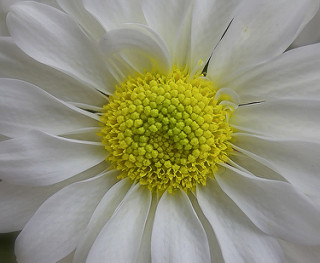

In [5]:
PIL.Image.open("./flower_photos/daisy/100080576_f52e8ee070_n.jpg")

## Load data

Let’s load these images off disk using the helpful tf.keras.utils.image_dataset_from_directory utility. This will take you from a directory of images on disk to a ```tf.data.Dataset``` in just a couple lines of code. We will divide the images in trainingtest, validationset and testset.
However, this modality of importing data is possible only if the task to carry out is a classification and the data is organized in directories where each directory represents a class.

In [6]:
d = 180
data = tf.keras.utils.image_dataset_from_directory(
  "flower_photos",
  validation_split=0.2,
  subset="both",
  seed=seed,
  image_size=(d, d),
  batch_size=32)

train_ds, val_ds = data

val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.skip(val_batches // 2)
val_ds = val_ds.take(val_batches // 2)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Using 734 files for validation.


In [7]:
class_names = train_ds.class_names
print(class_names)
num_classes = len(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


### Visualize data

After shuffling data, we can visualize some images from the training set to have an idea of the data we are working with.

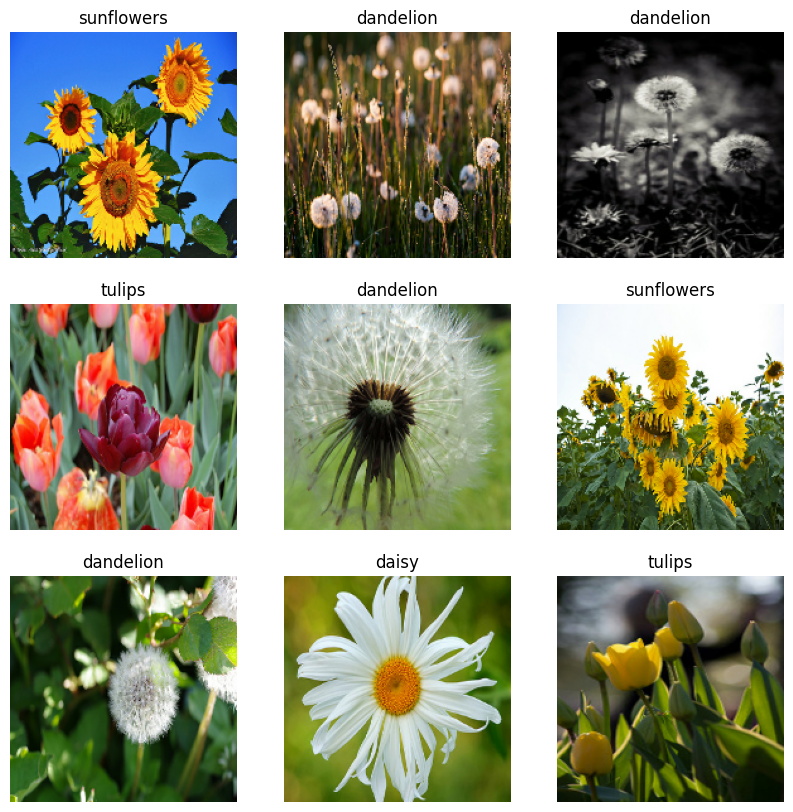

In [8]:
show_images(train_ds, class_names)

## Create and train a CNN model

In order to map all the channels of the images in the range [0, 1], we can apply a [Rescaling](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Rescaling) layer to normalize the input.

The lines of code below define the convolutional base using a common pattern: a stack of [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) and [MaxPooling2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D) layers.

As input, a CNN takes tensors of shape (image_height, image_width, color_channels), ignoring the batch size.

In [9]:
epochs_to_train = 10

In [10]:
base_model = get_model((d, d, 3), num_classes)
base_model.compile(optimizer=Adam(learning_rate=1e-3), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
base_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,989,285 (15.22 MB)

 Trainable params: 3,989,285 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
history = base_model.fit(train_ds, epochs=epochs_to_train, validation_data = val_ds)

Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 22s 177ms/step - accuracy: 0.3337 - loss: 1.5358 - val_accuracy: 0.4688 - val_loss: 1.1025
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.5531 - loss: 1.0785 - val_accuracy: 0.6364 - val_loss: 0.9741
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - accuracy: 0.6700 - loss: 0.8601 - val_accuracy: 0.6705 - val_loss: 0.8721
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 14s 52ms/step - accuracy: 0.7275 - loss: 0.6991 - val_accuracy: 0.7216 - val_loss: 0.8461
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - accuracy: 0.8214 - loss: 0.4877 - val_accuracy: 0.7045 - val_loss: 0.9073
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - accuracy: 0.8846 - loss: 0.3330 - val_accuracy: 0.7188 - val_loss: 1.0659
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - accuracy: 0.9246 - loss: 0.2189 - val_accuracy: 0.6534 - val_loss: 1.4108
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.9550 - loss: 0.1400 - val_accuracy: 0.71

Using a last layer with a `softmax` activation and `SparseCategoricalCrossentropy(from_logits = False)` is theoretically equivalent to omit the activation function and set `from_logits = True`.
This, though, in tensorflow is not always true and it is always better to exploit the `from_logits` parameter, [here](https://stackoverflow.com/questions/61233425/what-should-i-use-as-target-vector-when-i-use-binarycrossentropyfrom-logits-tru/61237426#61237426) you can find some reasons why.

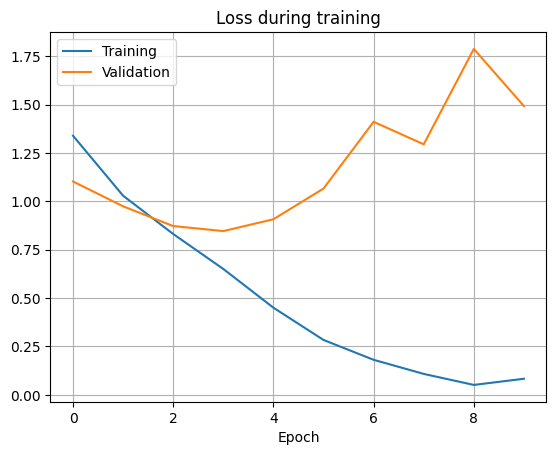

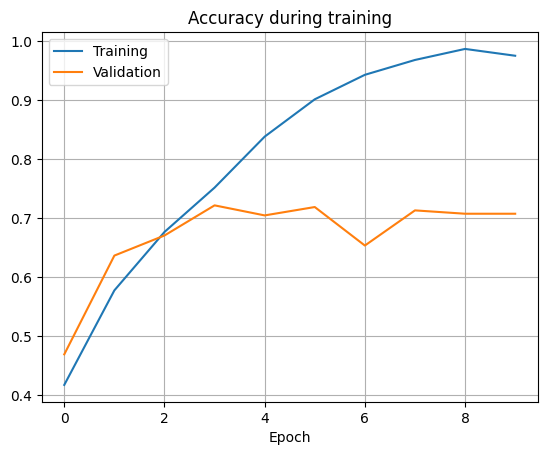

In [12]:
display_history(history)

## Regularization techniques

In the plots above, the training performances are increasing linearly over time, whereas validation ones are getting worse. Also, the difference in accuracy between training and validation accuracy is a noticeable sign of [overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit).

When there are a small number of training examples, the model sometimes learns from noises or unwanted details from training examples to an extent that it negatively impacts the performance of the model on new examples. This phenomenon is known as overfitting. It means that the model will have a difficult time generalizing on a new dataset.

There are multiple ways to fight overfitting in the training process. In this tutorial, you'll use *data augmentation* and add *Dropout* to your model.

### Data Augmentation

Overfitting generally occurs when there are a small number of training examples. [Data augmentation](./data_augmentation.ipynb) takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

You will implement data augmentation using the following Keras preprocessing layers: `tf.keras.layers.RandomFlip`, `tf.keras.layers.RandomRotation`, and `tf.keras.layers.RandomZoom`. These can be included inside your model like other layers, and run on the GPU.

In [13]:
data_augmentation = lambda input_shape: tf.keras.Sequential([
    RandomFlip("horizontal", input_shape=input_shape),
    RandomRotation(0.1),
    RandomZoom(0.1),
  ]
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


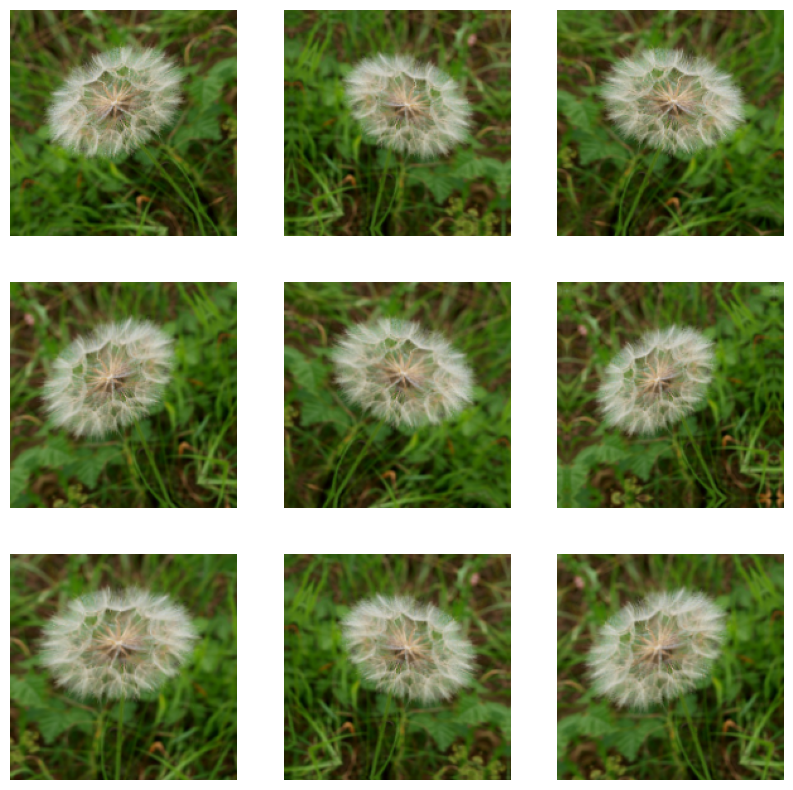

In [14]:
show_images(train_ds, class_names, data_augmentation=data_augmentation((d, d, 3)))

In [15]:
data_augmented_model = get_model((d, d, 3), num_classes, data_augmentation=data_augmentation)
data_augmented_model.compile(optimizer=Adam(learning_rate=1e-3), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
data_augmented_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ keras_tensor_20CLONE (InputLayer)    │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_1 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,989,285 (15.22 MB)

 Trainable params: 3,989,285 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
history = data_augmented_model.fit(train_ds, epochs=epochs_to_train, validation_data = val_ds)

Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 17s 155ms/step - accuracy: 0.3877 - loss: 1.4733 - val_accuracy: 0.5682 - val_loss: 1.0429
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - accuracy: 0.5979 - loss: 0.9990 - val_accuracy: 0.6193 - val_loss: 0.9595
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.6788 - loss: 0.8236 - val_accuracy: 0.6193 - val_loss: 1.0116
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - accuracy: 0.7574 - loss: 0.6524 - val_accuracy: 0.6989 - val_loss: 0.9176
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 0.8471 - loss: 0.4300 - val_accuracy: 0.7074 - val_loss: 0.9750
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 11s 68ms/step - accuracy: 0.9127 - loss: 0.2627 - val_accuracy: 0.7102 - val_loss: 1.0454
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step - accuracy: 0.9459 - loss: 0.1687 - val_accuracy: 0.7074 - val_loss: 1.3070
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - accuracy: 0.9697 - loss: 0.0843 - val_accuracy: 0.6875 

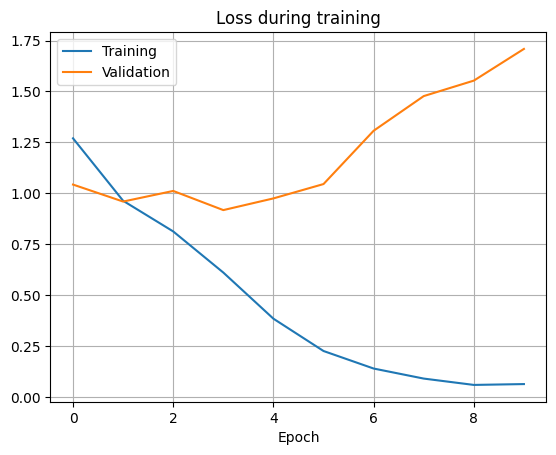

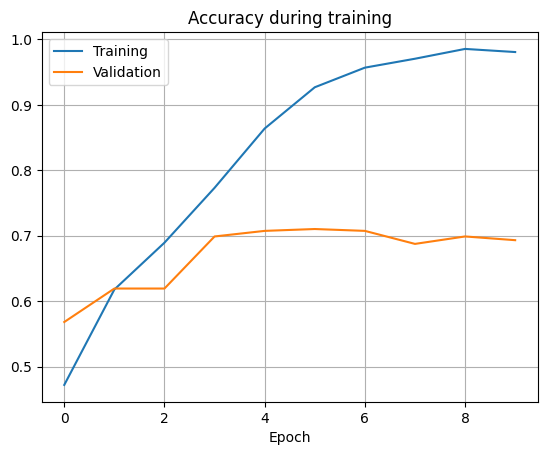

In [17]:
display_history(history)

### Dropout

Another technique to reduce overfitting is to introduce [dropout](https://developers.google.com/machine-learning/glossary#dropout_regularization) regularization to the network.

When you apply dropout to a layer, it randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

Let's create a new neural network with `tf.keras.layers.Dropout` before training it using the augmented images:

In [18]:
dropout_model = get_model((d, d, 3), num_classes, dropout_rate=0.2)
dropout_model.compile(optimizer=Adam(learning_rate=1e-3), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
dropout_model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_2 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,989,285 (15.22 MB)

 Trainable params: 3,989,285 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
history = dropout_model.fit(train_ds, epochs=epochs_to_train, validation_data = val_ds)

Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 18s 161ms/step - accuracy: 0.3537 - loss: 1.5016 - val_accuracy: 0.5994 - val_loss: 1.0559
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - accuracy: 0.5919 - loss: 1.0228 - val_accuracy: 0.6705 - val_loss: 0.8975
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - accuracy: 0.6876 - loss: 0.8105 - val_accuracy: 0.6960 - val_loss: 0.8550
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.7575 - loss: 0.6247 - val_accuracy: 0.6847 - val_loss: 0.9024
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 7s 66ms/step - accuracy: 0.8322 - loss: 0.4431 - val_accuracy: 0.6989 - val_loss: 0.8862
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - accuracy: 0.8939 - loss: 0.3061 - val_accuracy: 0.7216 - val_loss: 1.1220
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - accuracy: 0.9281 - loss: 0.2105 - val_accuracy: 0.6932 - val_loss: 1.3373
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - accuracy: 0.9630 - loss: 0.1131 - val_accuracy: 0.710

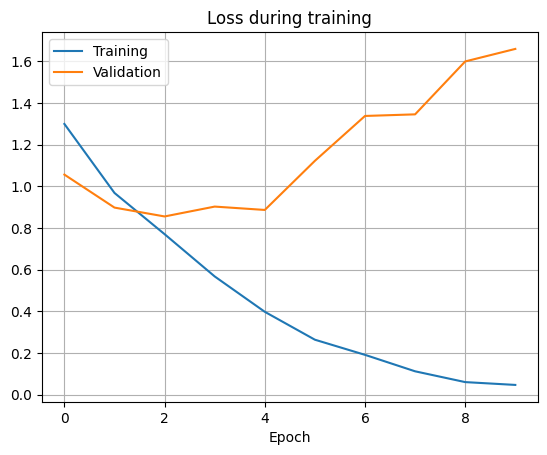

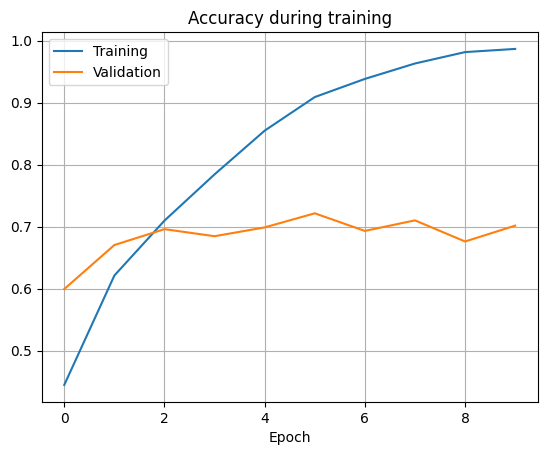

In [20]:
display_history(history)

## Hyperparameters Tuning

Deep learning models relies on a variable number of hyperparameters that need to be tuned in order to achieve the best performance. The hyperparameters are the parameters that are set before the learning process begins. They are not learned during the training process.
Hyperparameters are linked to the architecture of the model as well as the optimization algorithm used to train the model.

In [21]:
def objective(trial):
    # Define the search space
    activation = trial.suggest_categorical('activation', ['relu', 'elu', 'sigmoid', 'tanh'])
    padding = trial.suggest_categorical('padding', ['same', 'valid'])
    learning_rate = trial.suggest_float('learning_rate', 1e-3, 1e-2)
    kernel_size = trial.suggest_int('kernel_size', 2, 3)
    epochs = trial.suggest_int('epochs', 5, 15)
    dropout_rate = trial.suggest_float('dropout_rate', .0, .5)

    # Build and train the model using these hyperparameters
    model = get_model((d, d, 3), num_classes, activation=activation, padding=padding,
                                kernel_size=kernel_size ,dropout_rate=dropout_rate)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
    model.fit(train_ds, epochs=epochs, validation_data=val_ds)
    _, score = model.evaluate(val_ds)

    # if trial.study.best_trial is None or score > trial.study.best_trial.value:
    if len(trial.study.trials) == 1 or score > trial.study.best_trial.value:
        model.save(f'./models/model_trial_{trial.number}.keras')

    return score

sampler = optuna.samplers.RandomSampler(seed=seed)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=10)
best_model = tf.keras.models.load_model(f'./models/model_trial_{study.best_trial.number}.keras')
best_model.summary()

[I 2024-10-25 07:41:49,450] A new study created in memory with name: no-name-34fc2008-5ad5-438a-86f8-ac644ae8c17d


Epoch 1/11
92/92 ━━━━━━━━━━━━━━━━━━━━ 20s 177ms/step - accuracy: 0.3743 - loss: 2.7302 - val_accuracy: 0.5540 - val_loss: 1.1233
Epoch 2/11
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.5592 - loss: 1.0981 - val_accuracy: 0.6222 - val_loss: 1.0481
Epoch 3/11
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.6663 - loss: 0.8518 - val_accuracy: 0.5739 - val_loss: 1.0816
Epoch 4/11
92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - accuracy: 0.7452 - loss: 0.6927 - val_accuracy: 0.5994 - val_loss: 1.1043
Epoch 5/11
92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.8520 - loss: 0.4289 - val_accuracy: 0.6136 - val_loss: 1.2348
Epoch 6/11
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - accuracy: 0.8952 - loss: 0.3027 - val_accuracy: 0.6477 - val_loss: 1.2038
Epoch 7/11
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.9444 - loss: 0.1661 - val_accuracy: 0.6108 - val_loss: 1.4432
Epoch 8/11
92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - accuracy: 0.9613 - loss: 0.1191 - val_accuracy: 0.5938 

[I 2024-10-25 07:43:06,945] Trial 0 finished with value: 0.5710227489471436 and parameters: {'activation': 'elu', 'padding': 'same', 'learning_rate': 0.0015227525095137954, 'kernel_size': 3, 'epochs': 11, 'dropout_rate': 0.35403628889802274}. Best is trial 0 with value: 0.5710227489471436.


Epoch 1/9
92/92 ━━━━━━━━━━━━━━━━━━━━ 22s 198ms/step - accuracy: 0.2283 - loss: 6.9531 - val_accuracy: 0.2216 - val_loss: 1.5652
Epoch 2/9
92/92 ━━━━━━━━━━━━━━━━━━━━ 26s 67ms/step - accuracy: 0.2696 - loss: 1.5383 - val_accuracy: 0.2642 - val_loss: 1.4758
Epoch 3/9
92/92 ━━━━━━━━━━━━━━━━━━━━ 9s 53ms/step - accuracy: 0.3427 - loss: 1.4408 - val_accuracy: 0.3267 - val_loss: 1.5798
Epoch 4/9
92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 0.3386 - loss: 1.5373 - val_accuracy: 0.3324 - val_loss: 1.4530
Epoch 5/9
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.3433 - loss: 1.4272 - val_accuracy: 0.3153 - val_loss: 1.4177
Epoch 6/9
92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - accuracy: 0.3358 - loss: 1.4340 - val_accuracy: 0.4432 - val_loss: 1.3221
Epoch 7/9
92/92 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step - accuracy: 0.3766 - loss: 1.3638 - val_accuracy: 0.4517 - val_loss: 1.3112
Epoch 8/9
92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - accuracy: 0.4078 - loss: 1.3050 - val_accuracy: 0.4744 - val_lo

[I 2024-10-25 07:44:46,169] Trial 1 finished with value: 0.4630681872367859 and parameters: {'activation': 'elu', 'padding': 'valid', 'learning_rate': 0.00373818018663584, 'kernel_size': 3, 'epochs': 9, 'dropout_rate': 0.14561457009902096}. Best is trial 0 with value: 0.5710227489471436.


Epoch 1/11
92/92 ━━━━━━━━━━━━━━━━━━━━ 20s 175ms/step - accuracy: 0.3151 - loss: 1.7360 - val_accuracy: 0.4972 - val_loss: 1.1728
Epoch 2/11
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.4646 - loss: 1.2571 - val_accuracy: 0.5455 - val_loss: 1.1305
Epoch 3/11
92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.5318 - loss: 1.1309 - val_accuracy: 0.6023 - val_loss: 0.9952
Epoch 4/11
92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - accuracy: 0.5806 - loss: 1.0321 - val_accuracy: 0.6023 - val_loss: 0.9409
Epoch 5/11
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.6516 - loss: 0.8629 - val_accuracy: 0.5938 - val_loss: 1.0059
Epoch 6/11
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.7068 - loss: 0.7302 - val_accuracy: 0.5767 - val_loss: 1.0920
Epoch 7/11
92/92 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - accuracy: 0.7917 - loss: 0.5479 - val_accuracy: 0.6420 - val_loss: 1.2381
Epoch 8/11
92/92 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - accuracy: 0.8734 - loss: 0.3637 - val_accuracy: 0.6562 

[I 2024-10-25 07:46:08,821] Trial 2 finished with value: 0.6590909361839294 and parameters: {'activation': 'relu', 'padding': 'valid', 'learning_rate': 0.002797064039425238, 'kernel_size': 3, 'epochs': 11, 'dropout_rate': 0.023225206359998862}. Best is trial 2 with value: 0.6590909361839294.


Epoch 1/12
92/92 ━━━━━━━━━━━━━━━━━━━━ 19s 160ms/step - accuracy: 0.2089 - loss: 2.7098 - val_accuracy: 0.1591 - val_loss: 1.6120
Epoch 2/12
92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - accuracy: 0.2282 - loss: 1.6225 - val_accuracy: 0.2528 - val_loss: 1.6066
Epoch 3/12
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.2203 - loss: 1.6308 - val_accuracy: 0.1449 - val_loss: 1.6258
Epoch 4/12
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.2173 - loss: 1.6414 - val_accuracy: 0.2614 - val_loss: 1.5886
Epoch 5/12
92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.2190 - loss: 1.6405 - val_accuracy: 0.2614 - val_loss: 1.6174
Epoch 6/12
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.1880 - loss: 1.6397 - val_accuracy: 0.2614 - val_loss: 1.7051
Epoch 7/12
92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - accuracy: 0.2207 - loss: 1.6505 - val_accuracy: 0.2614 - val_loss: 1.5997
Epoch 8/12
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.2108 - loss: 1.6390 - val_accuracy: 0.1449 -

[I 2024-10-25 07:47:35,872] Trial 3 finished with value: 0.2613636255264282 and parameters: {'activation': 'tanh', 'padding': 'same', 'learning_rate': 0.0037415239225603364, 'kernel_size': 2, 'epochs': 12, 'dropout_rate': 0.22007624686980065}. Best is trial 2 with value: 0.6590909361839294.


Epoch 1/11
92/92 ━━━━━━━━━━━━━━━━━━━━ 18s 156ms/step - accuracy: 0.2325 - loss: 3.5601 - val_accuracy: 0.2614 - val_loss: 1.5962
Epoch 2/11
92/92 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - accuracy: 0.2066 - loss: 1.6182 - val_accuracy: 0.2614 - val_loss: 1.6224
Epoch 3/11
92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.2109 - loss: 1.6328 - val_accuracy: 0.2614 - val_loss: 1.6349
Epoch 4/11
92/92 ━━━━━━━━━━━━━━━━━━━━ 11s 66ms/step - accuracy: 0.2148 - loss: 1.6264 - val_accuracy: 0.2614 - val_loss: 1.6418
Epoch 5/11
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.2239 - loss: 1.6270 - val_accuracy: 0.2614 - val_loss: 1.5986
Epoch 6/11
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.2073 - loss: 1.6442 - val_accuracy: 0.2614 - val_loss: 1.5943
Epoch 7/11
92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - accuracy: 0.2152 - loss: 1.6536 - val_accuracy: 0.2614 - val_loss: 1.6008
Epoch 8/11
92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 65ms/step - accuracy: 0.2289 - loss: 1.6342 - val_accuracy: 0.2528

[I 2024-10-25 07:49:10,683] Trial 4 finished with value: 0.25284090638160706 and parameters: {'activation': 'tanh', 'padding': 'valid', 'learning_rate': 0.0038053996848046987, 'kernel_size': 3, 'epochs': 11, 'dropout_rate': 0.09242722776276352}. Best is trial 2 with value: 0.6590909361839294.


Epoch 1/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 19s 164ms/step - accuracy: 0.3235 - loss: 1.6235 - val_accuracy: 0.6023 - val_loss: 0.9890
Epoch 2/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.6232 - loss: 0.9524 - val_accuracy: 0.6307 - val_loss: 0.9212
Epoch 3/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 7s 78ms/step - accuracy: 0.7109 - loss: 0.7372 - val_accuracy: 0.6278 - val_loss: 0.9875
Epoch 4/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.8200 - loss: 0.4974 - val_accuracy: 0.6477 - val_loss: 1.1109
Epoch 5/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - accuracy: 0.9002 - loss: 0.2867 - val_accuracy: 0.6193 - val_loss: 1.3260
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.6188 - loss: 1.3755


[I 2024-10-25 07:49:58,119] Trial 5 finished with value: 0.6193181872367859 and parameters: {'activation': 'relu', 'padding': 'valid', 'learning_rate': 0.0017964325184672756, 'kernel_size': 2, 'epochs': 5, 'dropout_rate': 0.16266516538163217}. Best is trial 2 with value: 0.6590909361839294.


Epoch 1/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 19s 167ms/step - accuracy: 0.2148 - loss: 2.0980 - val_accuracy: 0.2614 - val_loss: 1.5945
Epoch 2/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - accuracy: 0.2404 - loss: 1.6065 - val_accuracy: 0.2614 - val_loss: 1.6171
Epoch 3/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.2182 - loss: 1.6151 - val_accuracy: 0.1449 - val_loss: 1.6104
Epoch 4/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - accuracy: 0.2147 - loss: 1.6152 - val_accuracy: 0.2614 - val_loss: 1.6148
Epoch 5/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - accuracy: 0.1966 - loss: 1.6185 - val_accuracy: 0.1449 - val_loss: 1.6440
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.1437 - loss: 1.6395


[I 2024-10-25 07:50:43,798] Trial 6 finished with value: 0.14488635957241058 and parameters: {'activation': 'sigmoid', 'padding': 'valid', 'learning_rate': 0.002268318024772864, 'kernel_size': 3, 'epochs': 5, 'dropout_rate': 0.49344346830025865}. Best is trial 2 with value: 0.6590909361839294.


Epoch 1/8
92/92 ━━━━━━━━━━━━━━━━━━━━ 17s 155ms/step - accuracy: 0.1997 - loss: 3.2390 - val_accuracy: 0.2528 - val_loss: 1.6069
Epoch 2/8
92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 65ms/step - accuracy: 0.1989 - loss: 1.6576 - val_accuracy: 0.1818 - val_loss: 1.6172
Epoch 3/8
92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - accuracy: 0.1836 - loss: 1.6584 - val_accuracy: 0.2528 - val_loss: 1.5852
Epoch 4/8
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - accuracy: 0.1868 - loss: 1.6451 - val_accuracy: 0.2614 - val_loss: 1.6562
Epoch 5/8
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.1976 - loss: 1.6746 - val_accuracy: 0.1449 - val_loss: 1.7323
Epoch 6/8
92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - accuracy: 0.1898 - loss: 1.6851 - val_accuracy: 0.2528 - val_loss: 1.6113
Epoch 7/8
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.2126 - loss: 1.6622 - val_accuracy: 0.2614 - val_loss: 1.6253
Epoch 8/8
92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.2109 - loss: 1.6490 - val_accuracy: 0.2528 - val_l

[I 2024-10-25 07:51:52,911] Trial 7 finished with value: 0.25284090638160706 and parameters: {'activation': 'tanh', 'padding': 'valid', 'learning_rate': 0.007941433120173511, 'kernel_size': 2, 'epochs': 8, 'dropout_rate': 0.05793452976256486}. Best is trial 2 with value: 0.6590909361839294.


Epoch 1/14
92/92 ━━━━━━━━━━━━━━━━━━━━ 18s 163ms/step - accuracy: 0.2420 - loss: 2.6779 - val_accuracy: 0.2670 - val_loss: 1.5663
Epoch 2/14
92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - accuracy: 0.2857 - loss: 1.5381 - val_accuracy: 0.3239 - val_loss: 1.5725
Epoch 3/14
92/92 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step - accuracy: 0.3058 - loss: 1.5414 - val_accuracy: 0.3750 - val_loss: 1.5183
Epoch 4/14
92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.3555 - loss: 1.4999 - val_accuracy: 0.3324 - val_loss: 1.5158
Epoch 5/14
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.3898 - loss: 1.4225 - val_accuracy: 0.4176 - val_loss: 1.3844
Epoch 6/14
92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - accuracy: 0.4654 - loss: 1.2554 - val_accuracy: 0.4290 - val_loss: 1.3779
Epoch 7/14
92/92 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - accuracy: 0.5243 - loss: 1.1653 - val_accuracy: 0.3949 - val_loss: 1.4585
Epoch 8/14
92/92 ━━━━━━━━━━━━━━━━━━━━ 7s 66ms/step - accuracy: 0.5679 - loss: 1.0879 - val_accuracy: 0.4517 -

[I 2024-10-25 07:53:29,286] Trial 8 finished with value: 0.40625 and parameters: {'activation': 'relu', 'padding': 'valid', 'learning_rate': 0.007566455605042577, 'kernel_size': 3, 'epochs': 14, 'dropout_rate': 0.23610746258097465}. Best is trial 2 with value: 0.6590909361839294.


Epoch 1/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 19s 162ms/step - accuracy: 0.1986 - loss: 1.9481 - val_accuracy: 0.2614 - val_loss: 1.6245
Epoch 2/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.1996 - loss: 1.6245 - val_accuracy: 0.2614 - val_loss: 1.5983
Epoch 3/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.2042 - loss: 1.6304 - val_accuracy: 0.1818 - val_loss: 1.6190
Epoch 4/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - accuracy: 0.2140 - loss: 1.6249 - val_accuracy: 0.2528 - val_loss: 1.6162
Epoch 5/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.1948 - loss: 1.6278 - val_accuracy: 0.2614 - val_loss: 1.6288
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.2789 - loss: 1.6135


[I 2024-10-25 07:54:15,266] Trial 9 finished with value: 0.2613636255264282 and parameters: {'activation': 'sigmoid', 'padding': 'same', 'learning_rate': 0.005704595464437947, 'kernel_size': 2, 'epochs': 5, 'dropout_rate': 0.053945713496652226}. Best is trial 2 with value: 0.6590909361839294.


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)           │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_5 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 178, 178, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 89, 89, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 87, 87, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 43, 43, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 41, 41, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 20, 20, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 20, 20, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 25600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 128)                 │       3,276,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,903,473 (37.78 MB)

 Trainable params: 3,301,157 (12.59 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 6,602,316 (25.19 MB)

After the hyperparameter tuning, we obtain the best model that is saved in the `best_model` variable, while other features of the optimization process are stored in the `study` variable. All the details of the optimization process can be accessed on the website of [optuna](https://optuna.org).

## Transfer Learning and Fine-Tuning

In this example, we will see how to apply transfer learning and fine-tuning exploiting a pre-trained network.

A pre-trained model is a saved network that was previously trained on a large dataset, typically on a large-scale classification task. You either use the pretrained model as it is or use transfer learning to customize this model to a given task.

The intuition behind transfer learning for image classification is that if a model is trained on a large and general enough dataset, this model will effectively serve as a generic model. You can then take advantage of these learned feature maps without having to start from scratch by training a large model on a large dataset.

There are mainly two ways to use a pretrained model:

1. Feature Extraction: Use the representations learned by a previous network to extract meaningful features from new samples. You simply add a new classifier, which will be trained from scratch, on top of the pretrained model so that you can repurpose the feature maps learned previously for the dataset.
You do not need to (re)train the entire model. The base network already contains features that are generically useful for the task. However, the final classification part of the pretrained model is specific to the original classification task and subsequently specific to the set of classes on which the model was trained.

2. Fine-Tuning: Unfreeze a few of the top layers of a frozen model base and jointly train both the newly-added classifier layers and the last layers of the base model. This allows us to "fine-tune" the higher-order feature representations in the base model in order to make them more relevant for the specific task.

We will create the base model from the **MobileNet V2**, developed at Google. This is a pre-trained model on the ImageNet dataset, a large dataset consisting of 14M images and 1000 classes. ImageNet is a research training dataset with a wide variety of categories like `jackfruit` and `syringe`. This base of knowledge will help us classify images from our specific dataset.

First, you need to pick which layer of MobileNet V2 you will use for feature extraction. The very last classification layer (on "top", as most diagrams of machine learning models go from bottom to top) is not very useful. Instead, you will follow the common practice to depend on the very last layer before the flatten operation. This layer is called the "bottleneck layer". The bottleneck layer features retain more generality as compared to the final/top layer.

First, instantiate a MobileNet V2 model pre-loaded with weights trained on ImageNet. By specifying the **include_top=False** argument, you load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

In [22]:
mobile_net = tf.keras.applications.MobileNetV2(input_shape=(d, d, 3),
                                               include_top=False,
                                               weights='imagenet')
# Let's take a look at the base model architecture
mobile_net.summary()

<ipython-input-22-51108a724e79>:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobile_net = tf.keras.applications.MobileNetV2(input_shape=(d, d, 3),


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_15            │ (None, 180, 180, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 90, 90, 32)     │            864 │ input_layer_15[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 90, 90, 32)     │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 90, 90, 32)     │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 90, 90, 32)     │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 90, 90, 32)     │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 90, 90, 32)     │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 90, 90, 16)     │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 90, 90, 16)     │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 90, 90, 96)     │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 90, 90, 96)     │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 90, 90, 96)     │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 91, 91, 96)     │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 45, 45, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 2,223,872 (8.48 MB)

 Non-trainable params: 34,112 (133.25 KB)

## Feature extraction
In this step, we will freeze the convolutional base created from the previous step and to use as a feature extractor. Additionally, you add a classifier on top of it and train the top-level classifier.

It is important to freeze the convolutional base before you compile and train the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. MobileNet V2 has many layers, so setting the entire model's `trainable` flag to False will freeze all of them.

In [23]:
mobile_net.trainable = False
mobile_net.summary()

Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_15            │ (None, 180, 180, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 90, 90, 32)     │            864 │ input_layer_15[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 90, 90, 32)     │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 90, 90, 32)     │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 90, 90, 32)     │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 90, 90, 32)     │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 90, 90, 32)     │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 90, 90, 16)     │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 90, 90, 16)     │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 90, 90, 96)     │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 90, 90, 96)     │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 90, 90, 96)     │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 91, 91, 96)     │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 45, 45, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

### Important note about BatchNormalization layers

Many models contain `tf.keras.layers.BatchNormalization` layers. This layer is a special case and precautions should be taken in the context of fine-tuning, as shown later in this tutorial.

When we set `layer.trainable = False`, the `BatchNormalization` layer will run in inference mode, and will not update its mean and variance statistics.

When we unfreeze a model that contains BatchNormalization layers in order to do fine-tuning, we should keep the BatchNormalization layers in inference mode by passing `training = False` when calling the base model. Otherwise, the updates applied to the non-trainable weights will destroy what the model has learned.

For more details, see the [Transfer learning guide](https://www.tensorflow.org/guide/keras/transfer_learning).

Let's add now the classification head layer

In [24]:
fine_tune_model = get_pre_trained_model((d, d, 3), num_classes, mobile_net)
starting_lr = 1e-4
initial_epochs = 10

fine_tune_model.compile(optimizer=Adam(learning_rate=starting_lr),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics=['accuracy'])
fine_tune_model.summary()

Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)          │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_2 (Sequential)            │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_13 (Rescaling)             │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 6, 6, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 5)                   │           6,405 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,264,389 (8.64 MB)

 Trainable params: 6,405 (25.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 14s 71ms/step - accuracy: 0.2146 - loss: 2.0217 - val_accuracy: 0.4716 - val_loss: 1.2998
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - accuracy: 0.4351 - loss: 1.3824 - val_accuracy: 0.6875 - val_loss: 0.9432
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.6009 - loss: 1.0611 - val_accuracy: 0.7727 - val_loss: 0.7563
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - accuracy: 0.6746 - loss: 0.8732 - val_accuracy: 0.8040 - val_loss: 0.6479
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.7187 - loss: 0.7867 - val_accuracy: 0.8182 - val_loss: 0.5804
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.7563 - loss: 0.7013 - val_accuracy: 0.8381 - val_loss: 0.5297
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - accuracy: 0.7626 - loss: 0.6707 - val_accuracy: 0.8438 - val_loss: 0.4972
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - accuracy: 0.7816 - loss: 0.6093 - val_accuracy: 0.8466 -

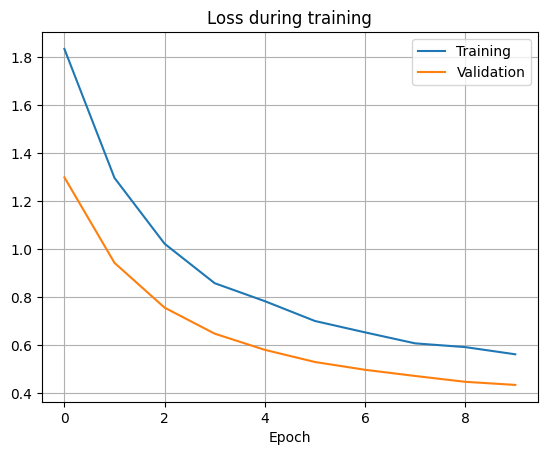

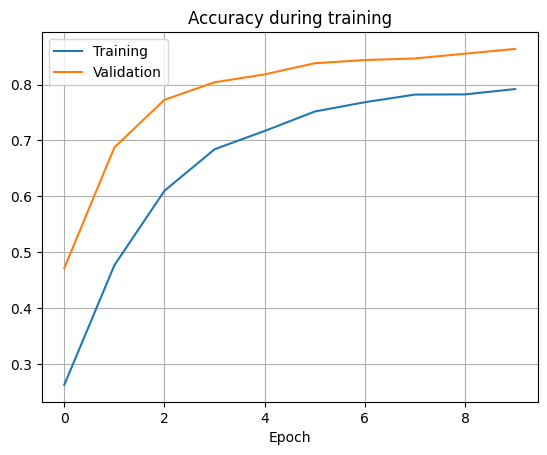

In [25]:
history = fine_tune_model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)
display_history(history)

## Fine tuning

In the feature extraction experiment, you were only training a few layers on top of an MobileNetV2 base model. The weights of the pre-trained network were not updated during training.

One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier you added. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.

Also, you should try to fine-tune a small number of top layers rather than the whole MobileNet model. In most convolutional networks, the higher up a layer is, the more specialized it is. The first few layers learn very simple and generic features that generalize to almost all types of images. As you go higher up, the features are increasingly more specific to the dataset on which the model was trained. The goal of fine-tuning is to adapt these specialized features to work with the new dataset, rather than overwrite the generic learning.

In [26]:
mobile_net.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in mobile_net.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  11


### Compile the model

As you are training a much larger model and want to readapt the pretrained weights, it is important to use a lower learning rate at this stage. Otherwise, your model could overfit very quickly.

In [27]:
fine_tune_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              optimizer = tf.keras.optimizers.Adam(learning_rate=starting_lr/10),
              metrics=['accuracy'])
fine_tune_model.summary()

Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)          │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_2 (Sequential)            │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_13 (Rescaling)             │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 6, 6, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 5)                   │           6,405 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,264,389 (8.64 MB)

 Trainable params: 1,867,845 (7.13 MB)

 Non-trainable params: 396,544 (1.51 MB)

In [28]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = fine_tune_model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds)

Epoch 10/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 23s 104ms/step - accuracy: 0.7065 - loss: 0.7926 - val_accuracy: 0.8636 - val_loss: 0.3769
Epoch 11/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 90ms/step - accuracy: 0.7800 - loss: 0.5943 - val_accuracy: 0.8750 - val_loss: 0.3399
Epoch 12/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 9s 78ms/step - accuracy: 0.8202 - loss: 0.4852 - val_accuracy: 0.8807 - val_loss: 0.3178
Epoch 13/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - accuracy: 0.8448 - loss: 0.4329 - val_accuracy: 0.8949 - val_loss: 0.3025
Epoch 14/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 89ms/step - accuracy: 0.8651 - loss: 0.3800 - val_accuracy: 0.9034 - val_loss: 0.2852
Epoch 15/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - accuracy: 0.8784 - loss: 0.3577 - val_accuracy: 0.9034 - val_loss: 0.2756
Epoch 16/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 7s 80ms/step - accuracy: 0.8805 - loss: 0.3143 - val_accuracy: 0.8977 - val_loss: 0.2739
Epoch 17/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 90ms/step - accuracy: 0.9049 - loss: 0.2824 - val_accuracy

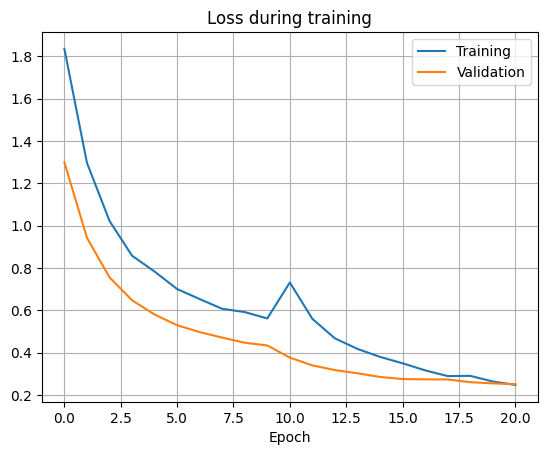

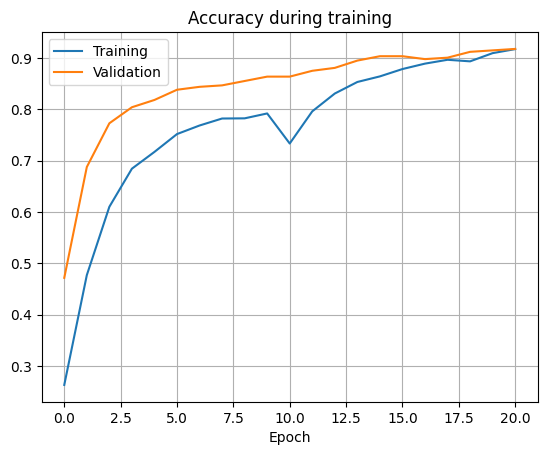

In [29]:
append_history(history, history_fine)
display_history(history)

## Generalization Results

In [30]:
print(f'Base Model accuracy on testset: {base_model.evaluate(test_ds)[1]}')
print(f'Data Augmented Model accuracy on testset: {data_augmented_model.evaluate(test_ds)[1]}')
print(f'Dropout Model accuracy on testset: {dropout_model.evaluate(test_ds)[1]}')
print(f'HP Optimized Model accuracy on testset: {best_model.evaluate(test_ds)[1]}')
print(f'Fine-tuned Model accuracy on testset: {fine_tune_model.evaluate(test_ds)[1]}')

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 0.6086 - loss: 1.8339
Base Model accuracy on testset: 0.5916230082511902
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.6415 - loss: 2.1271
Data Augmented Model accuracy on testset: 0.6204188466072083
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.6537 - loss: 2.1306
Dropout Model accuracy on testset: 0.6492146849632263
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - accuracy: 0.5762 - loss: 2.6208
HP Optimized Model accuracy on testset: 0.5785340070724487
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 0.8768 - loss: 0.3653
Fine-tuned Model accuracy on testset: 0.8664921522140503


# Exercises

On Flower_photos dataset:
* Run hyper-parameter tuning on the fine-tuned model.
* Try different pre-trained models for transfer learning.
* Try regularization techniques such as L2 regularization.

On butterflies dataset [butterflies_dataset](https://liveunibo-my.sharepoint.com/:u:/g/personal/angelo_quarta2_unibo_it/ERQoW97OqNBKlQKhQO_mY8MBLglpkw3VbmsXFDCLPgFZNA?e=swsLqD):
* Solve classification task without using transfer learning (use a custom architecture that is not from the ```tf.keras.applications``` library).
* Solve classification task using transfer learning.

N.B. During the solution of the butterflies dataset classification task, attempt to improve the model's performance as much as you can employing hyper-parameter tuning, regularization techniques and modification of the architecture where possible.